Reference tutorial: [Link](https://www.tensorflow.org/tutorials/structured_data/time_series)

### Useful imports and setup

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### Load data

In [2]:
DATA_PATH = '../data/extract.txt'

cols_map = {
    "DTS": "crossTime",
    #"LANE": "lane",
    #"DIR": "direction",
    "SPD": "speed",
    "AX": "nAxles",
    "GW_TOT": "weight",
    "TYPE": "type",
}

data = pd.read_csv(DATA_PATH, usecols=cols_map.keys())
data.rename(columns=cols_map, inplace=True)
# Parse crossTime column as datetime object
data.crossTime = pd.to_datetime(data.crossTime, format="%Y%m%dT%H%M%S")
# Convert type column to <category> object
data['type'] = data.type.astype('category')

data.head()

,crossTime,speed,nAxles,weight,type
0,2000-01-04 00:05:57,101,2,17930,11
1,2000-01-04 00:28:24,83,2,5230,11
2,2000-01-04 00:34:57,84,2,8310,11
3,2000-01-04 01:14:14,89,2,7550,11
4,2000-01-04 02:25:26,104,3,20930,12


### Data description

In [3]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
speed,9999.0,88.238024,7.028601,21.0,85.0,88.0,89.0,184.0
nAxles,9999.0,3.225723,1.111846,2.0,2.0,3.0,4.0,8.0
weight,9999.0,12335.469547,6135.098224,3500.0,7630.0,11440.0,15630.0,52440.0


### Feature engineering
- Datetime column `crossTime` not useful in its string form. We extract time of day, time of the week, and/or time of the year information to analyse periodicity. In order to deal with periodicity, we use sine and cosine transforms to get usable signals.

In [4]:
# Transform to seconds
timestamp_s = data.crossTime.map(pd.Timestamp.timestamp)

# Corresponding length in seconds for day, week, year
minute_s = 60
hour_s = minute_s * 60
day_s = 24 * hour_s # 24h x 60m x 60s
week_s = 7 * day_s
year_s = 365.2425 * day_s

In [5]:
def add_time_period_cols(time_length, time_string):
    data[time_string + '_sin'] = np.sin(timestamp_s * (2 * np.pi / time_length))
    data[time_string + '_cos'] = np.cos(timestamp_s * (2 * np.pi / time_length))
    
add_time_period_cols(day_s, 'day')
add_time_period_cols(week_s, 'week')

Text(0.5, 1.0, 'Sin transformed time signal')

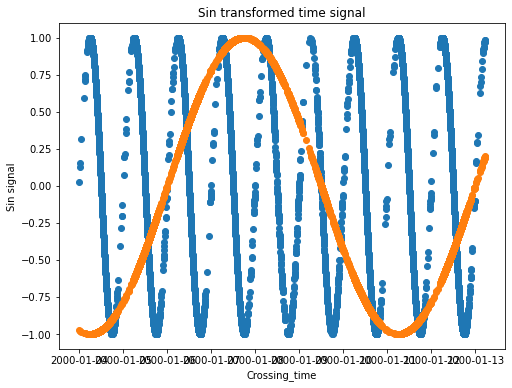

In [6]:
plt.scatter(y=np.array(data['day_sin']), x=data['crossTime'])
plt.scatter(y=np.array(data['week_sin']), x=data['crossTime'])
plt.ylabel('Sin signal')
plt.xlabel('Crossing_time')
plt.title('Sin transformed time signal')

As shown above, we obtain a nice periodic signal with respect to the time of day, time of week, and time of year.

### Split data

We use a (70%, 20%, 10%) split for the training, validation, and test sets. The data is not being randomly shuffled before splitting. This is for two reasons:

- It ensures that chopping the data into windows of consecutive samples is still possible.
- It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

In [7]:
y, X = data['crossTime'], data.drop(['crossTime', 'type'], axis=1).copy()

column_indices = {name: i for i, name in enumerate(X.columns)}

n = len(X.index)
train_data = X[0:int(n*0.7)]
val_data = X[int(n*0.7):int(n*0.9)]
test_data = X[int(n*0.9):]

n_features = X.shape[1]

In [8]:
train_data.head()

,speed,nAxles,weight,day_sin,day_cos,week_sin,week_cos
0,101,2,17930,0.025959,0.999663,-0.975746,-0.218904
1,83,2,5230,0.123601,0.992332,-0.978714,-0.205228
2,84,2,8310,0.151908,0.988395,-0.979544,-0.201231
3,89,2,7550,0.318270,0.948000,-0.984177,-0.177187
4,104,3,20930,0.592833,0.805325,-0.991069,-0.133348


### Normalize data

In [9]:
train_mean = train_data.mean()
train_std = train_data.std()

train_data = (train_data - train_mean) / train_std
val_data = (val_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

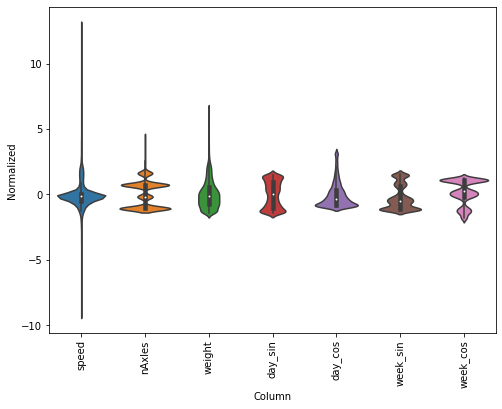

In [10]:
X_std = (X - train_mean) / train_std
X_std = X_std.melt(var_name='Column', value_name='Normalized')
ax = sns.violinplot(x='Column', y='Normalized', data=X_std)
_ = ax.set_xticklabels(X.keys(), rotation=90)

### Data windowing

In [11]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_data, val_df=val_data, test_df=test_data,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [12]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['weight'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['weight']

In [13]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['weight'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['weight']

In [14]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [15]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_data[:w2.total_window_size]),
                           np.array(train_data[100:100+w2.total_window_size]),
                           np.array(train_data[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 7)
Inputs shape: (3, 6, 7)
Labels shape: (3, 1, 1)


In [16]:
w2.example = example_inputs, example_labels

In [17]:
def plot(self, model=None, plot_col='weight', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

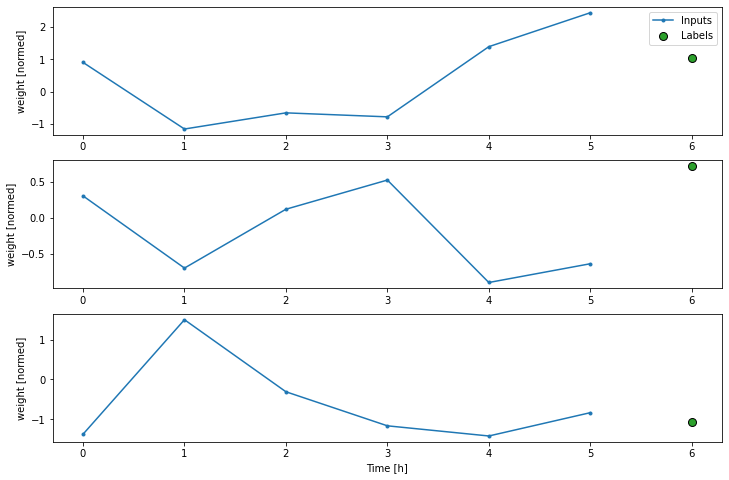

In [18]:
w2.plot()

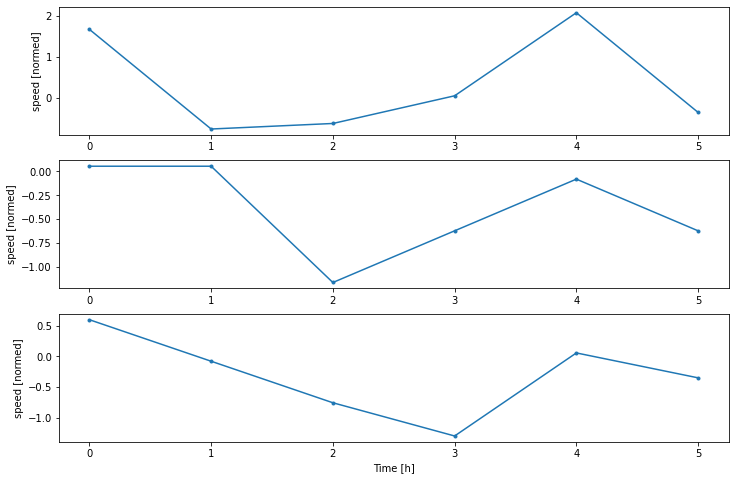

In [19]:
w2.plot(plot_col='speed')

In [20]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds


WindowGenerator.make_dataset = make_dataset


In [21]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [22]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 7), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [23]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 7)
Labels shape (batch, time, features): (32, 1, 1)


### Single step models
The simplest model we can build on this sort of data is one that predicts a single feature's value—1 time step into the future based only on the current conditions.

In [24]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['weight'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['weight']

In [25]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 7)
Labels shape (batch, time, features): (32, 1, 1)


#### Baseline
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

In [26]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [27]:
baseline = Baseline(label_index=column_indices['weight'])


baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: 1.9620 - mean_absolute_error: 1.0987


In [28]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['weight'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['weight']

In [29]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


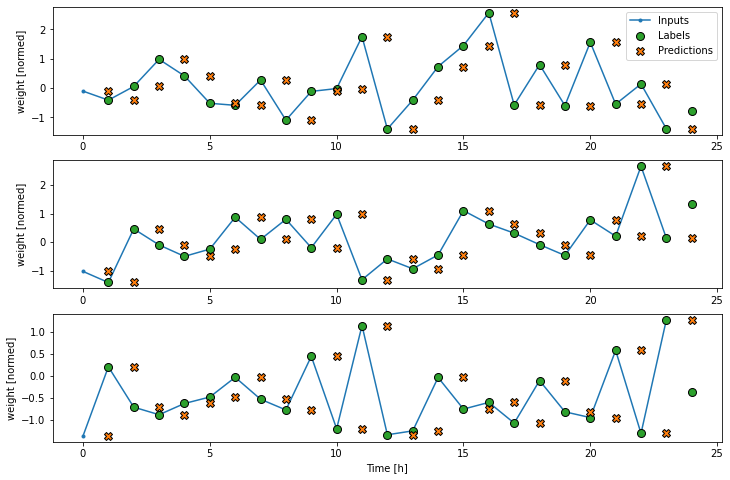

In [30]:
wide_window.plot(baseline)

#### Linear
The simplest trainable model we can apply to this task is to insert linear transformation between the input and output.

In [31]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [32]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 7)
Output shape: (32, 1, 1)


In [33]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history


In [34]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 2.1293 - mean_absolute_error: 1.1317 - val_loss: 1.8873 - val_mean_absolute_error: 1.0404
Epoch 2/20
219/219 [==============================] - 1s 2ms/step - loss: 1.5583 - mean_absolute_error: 0.9700 - val_loss: 1.4582 - val_mean_absolute_error: 0.9164
Epoch 3/20
219/219 [==============================] - 1s 2ms/step - loss: 1.2723 - mean_absolute_error: 0.8803 - val_loss: 1.2462 - val_mean_absolute_error: 0.8597
Epoch 4/20
219/219 [==============================] - 1s 2ms/step - loss: 1.1321 - mean_absolute_error: 0.8336 - val_loss: 1.1422 - val_mean_absolute_error: 0.8352
Epoch 5/20
219/219 [==============================] - 1s 2ms/step - loss: 1.0626 - mean_absolute_error: 0.8110 - val_loss: 1.0916 - val_mean_absolute_error: 0.8243
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 1.0278 - mean_absolute_error: 0.7998 - val_loss: 1.0651 - val_mean_absolute_error: 0.8187
Epoch 7/20
219/2

Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


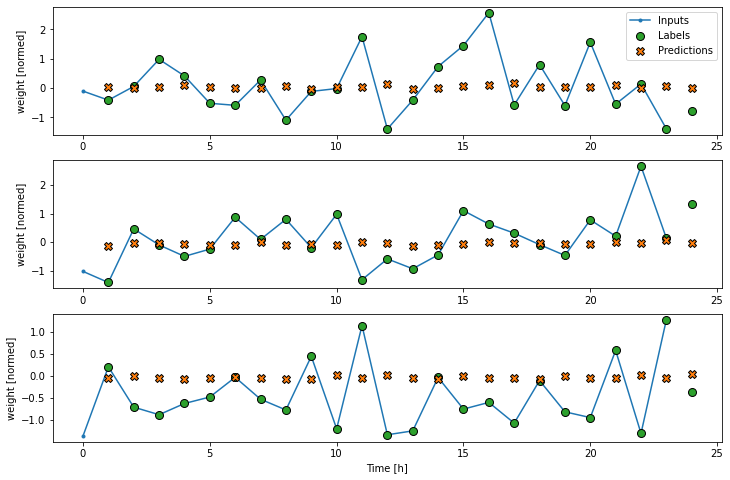

In [35]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

wide_window.plot(linear)

We pull out the layer's weights and visualize the weight assigned to each input:

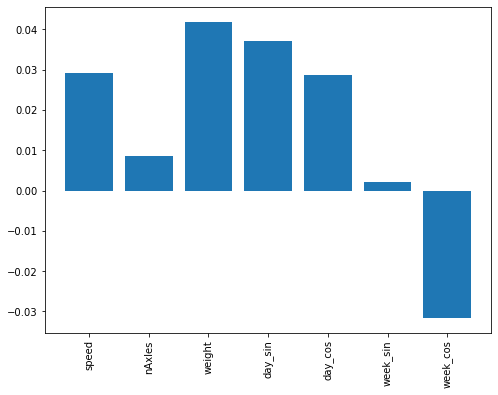

In [36]:
plt.bar(x = range(len(train_data.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_data.columns)))
_ = axis.set_xticklabels(train_data.columns, rotation=90)


#### Dense
Before applying models that actually operate on multiple time-steps, it's worth checking the performance of deeper, more powerful, single input step models. Similar to the linear model, except it stacks several a few Dense layers between the input and the output:

In [37]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 1.0113 - mean_absolute_error: 0.7992 - val_loss: 1.0474 - val_mean_absolute_error: 0.8070
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.9950 - mean_absolute_error: 0.7907 - val_loss: 1.0470 - val_mean_absolute_error: 0.8074
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.9889 - mean_absolute_error: 0.7882 - val_loss: 1.0474 - val_mean_absolute_error: 0.8062
Epoch 4/20
63/63 [==============================] - 0s 2ms/step - loss: 1.0484 - mean_absolute_error: 0.8063


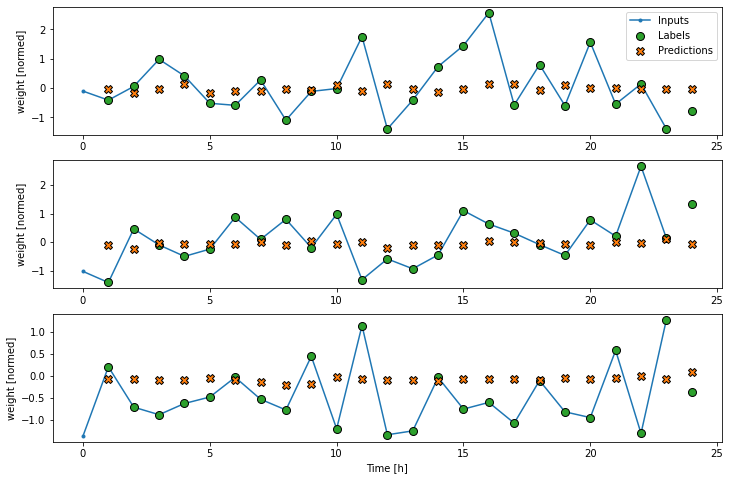

In [38]:
wide_window.plot(dense)

#### Multi step  dense
A single-time-step model has no context for the current values of its inputs. It can't see how the input features are changing over time. To address this issue the model needs access to multiple time steps when making predictions:

In [39]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['weight'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['weight']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

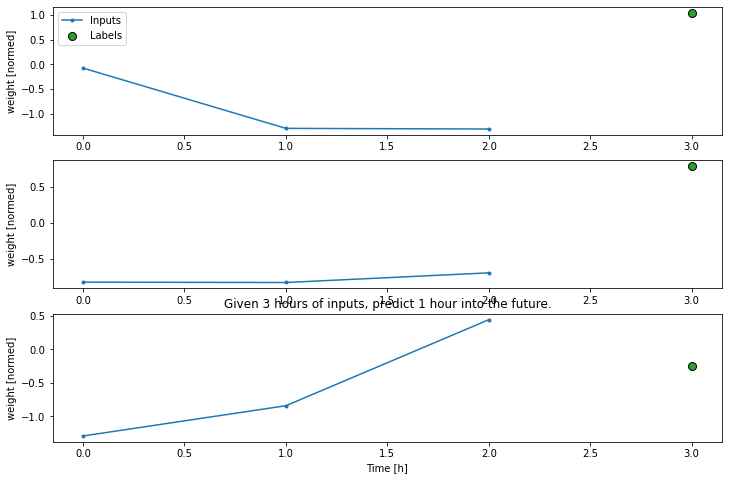

In [40]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")


In [41]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])


In [42]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)


Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [43]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

63/63 [==============================] - 0s 2ms/step - loss: 1.0476 - mean_absolute_error: 0.8141


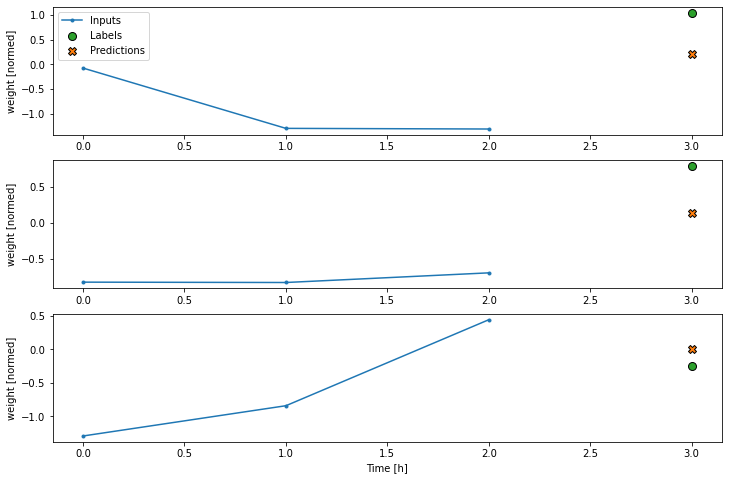

In [44]:
conv_window.plot(multi_step_dense)

#### Convolutional NN

In [45]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [46]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)


Conv model on `conv_window`
Input shape: (32, 3, 7)
Output shape: (32, 1, 1)


In [47]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)


63/63 [==============================] - 0s 2ms/step - loss: 1.0552 - mean_absolute_error: 0.8064


In [48]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [49]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['weight'])

wide_conv_window


Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['weight']

In [50]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)


Wide conv window
Input shape: (32, 26, 7)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding time steps:

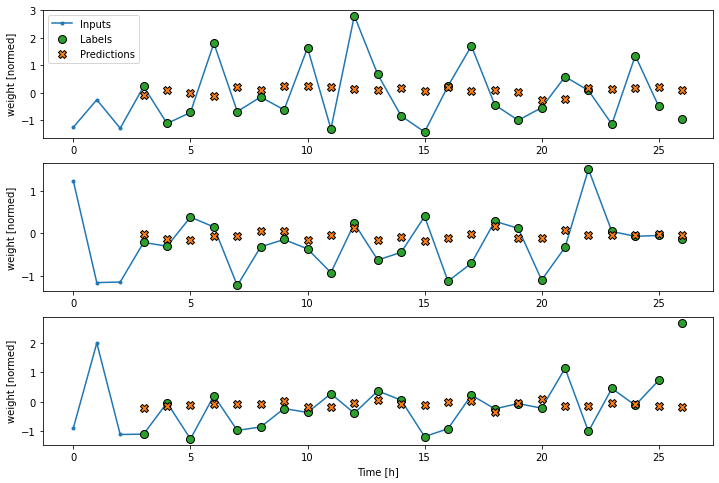

In [51]:
wide_conv_window.plot(conv_model)

#### RNN
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [52]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])


In [53]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)


Input shape: (32, 24, 7)
Output shape: (32, 24, 1)


In [54]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)


62/62 [==============================] - 0s 3ms/step - loss: 1.0589 - mean_absolute_error: 0.8162


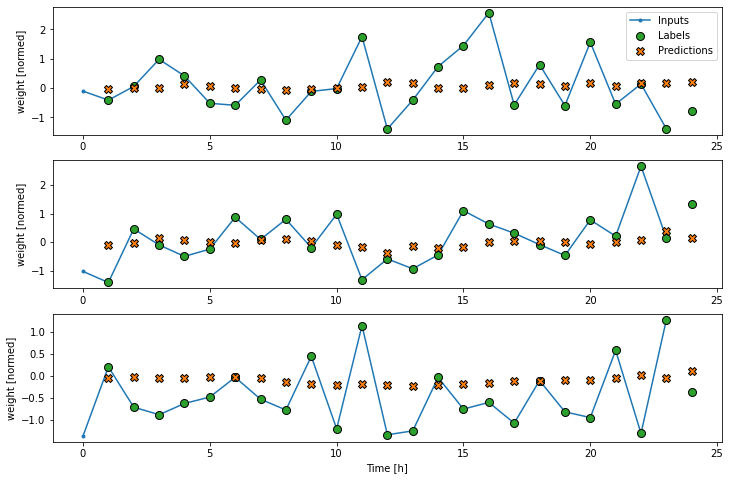

In [59]:
wide_window.plot(lstm_model)

#### Performance

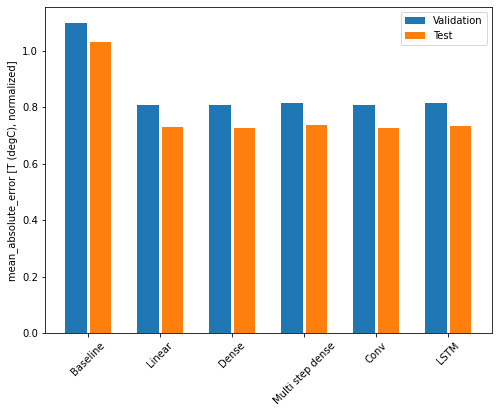

In [55]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = dense.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [56]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


Baseline    : 1.0304
Linear      : 0.7296
Dense       : 0.7267
Multi step dense: 0.7369
Conv        : 0.7274
LSTM        : 0.7344


### Multi-output model
The models so far all predicted a single output feature, for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels.

In [60]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 7)
Labels shape (batch, time, features): (32, 24, 7)


#### Baseline

In [62]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)

62/62 [==============================] - 0s 2ms/step - loss: 0.7090 - mean_absolute_error: 0.3977


#### Dense

In [64]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=n_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

63/63 [==============================] - 0s 1ms/step - loss: 0.3842 - mean_absolute_error: 0.3334


#### RNN

In [66]:
%%time
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=n_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

62/62 [==============================] - 0s 4ms/step - loss: 0.3916 - mean_absolute_error: 0.3381

Wall time: 23 s


#### Advanced: Residual connections
Changes between time step not necessarily small so skip this for now

### Multi-step models
In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

- Single shot predictions where the entire time series is predicted at once.
- Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.
In this section all the models will predict all the features across all output time steps.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24 hours into the future, given 24 hours of the past.

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

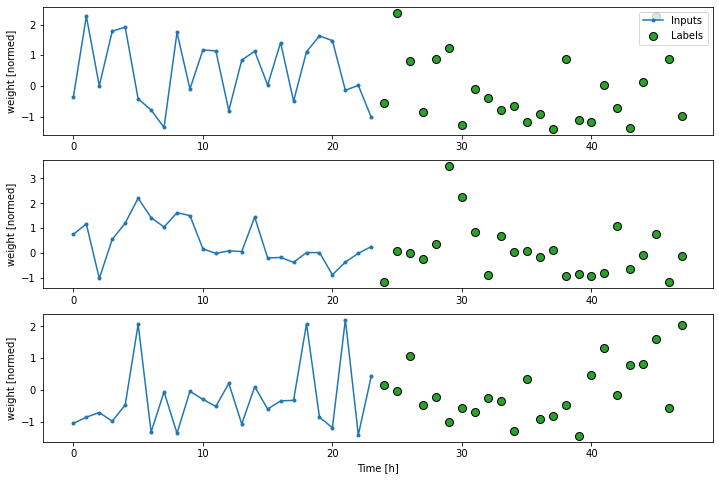

In [67]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

#### Baselines
A simple baseline for this task is to repeat the last input time step for the required number of output time steps:

62/62 [==============================] - 0s 2ms/step - loss: 0.7610 - mean_absolute_error: 0.4317


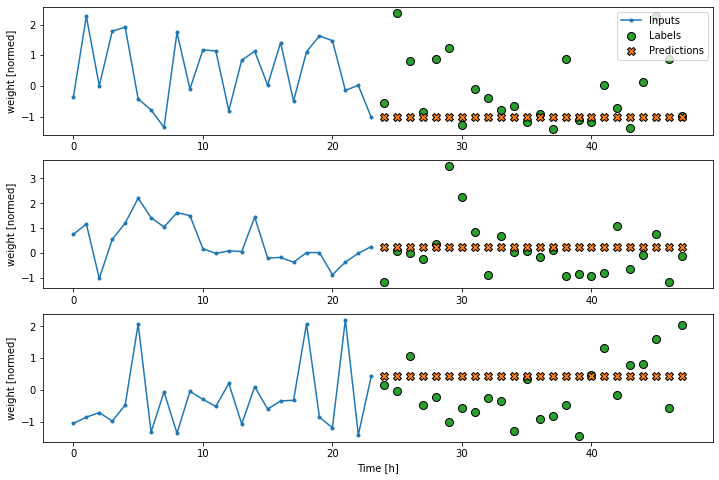

In [68]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

#### Single-shot models
One high-level approach to this problem is to use a "single-shot" model, where the model makes the entire sequence prediction in a single step.
#### Linear

62/62 [==============================] - 0s 2ms/step - loss: 0.3939 - mean_absolute_error: 0.3378


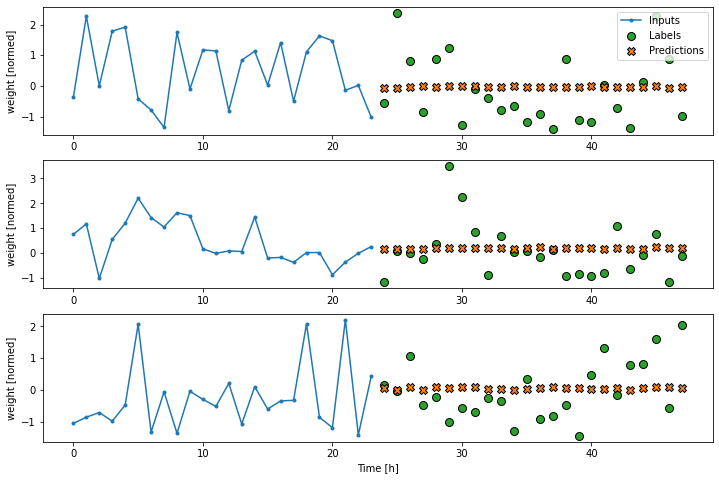

In [70]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

#### Dense

62/62 [==============================] - 0s 2ms/step - loss: 0.3934 - mean_absolute_error: 0.3331


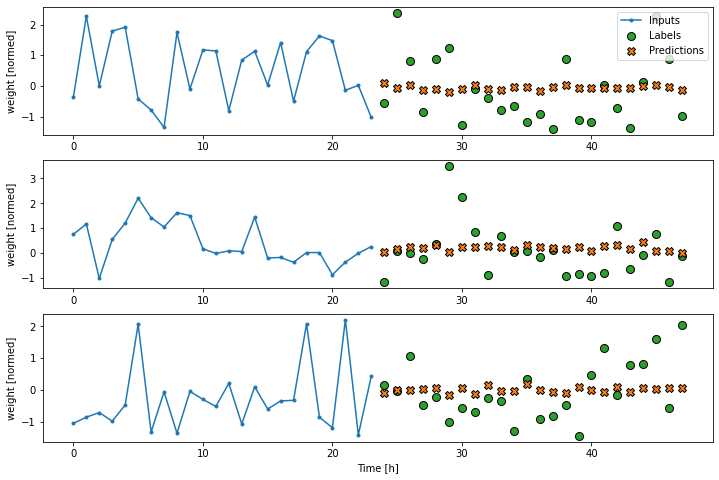

In [72]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

62/62 [==============================] - 0s 2ms/step - loss: 0.3905 - mean_absolute_error: 0.3317


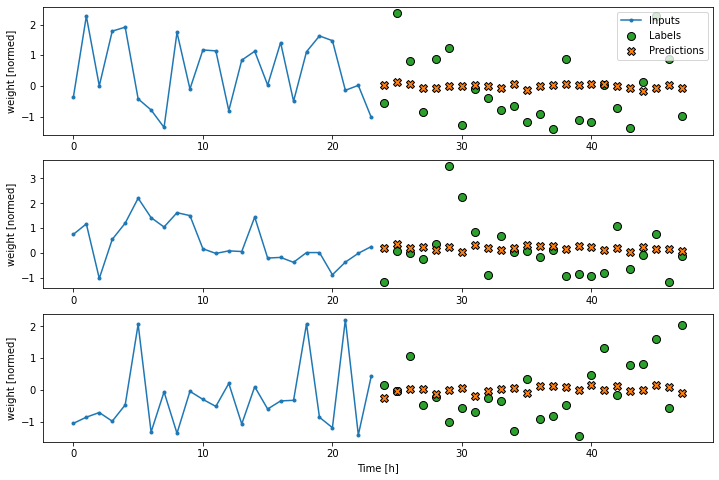

In [74]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

62/62 [==============================] - 0s 3ms/step - loss: 0.3863 - mean_absolute_error: 0.3296


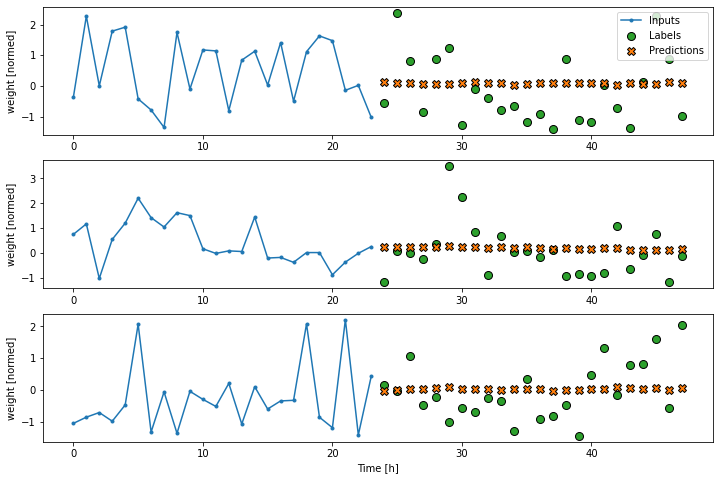

In [76]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*n_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, n_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

#### Autoregressive model
#### RNN
(skipped for now)

#### Performance

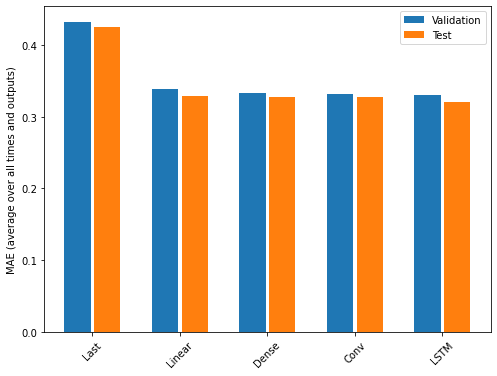

In [77]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [78]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4250
Linear  : 0.3284
Dense   : 0.3269
Conv    : 0.3271
LSTM    : 0.3202


### Comments:
- Pour l'instant la x-axis de nos graphes ne correspondent pas à des steps de 1h
- Peut-être resample les données dès le début à genre toutes les 15min, 30min, ou 1h pour avoir des regular time steps
- Need data analysis sur la distribution des time-step, etc. to make a good decision
- Choisir la taille de notre window